# Wasserstein variance influence
A question which pup up is, how much difference is influenced by the variance or the mean.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import utils
import scipy

In [2]:
def wasserstein(mu1, var1, mu2, var2):
    return np.sqrt(
        ( mu1 - mu2 )**2 + ( np.sqrt(var1) - np.sqrt(var2) )**2
    )

def wasserstein_matrix(mu1, var1, mu2, var2):
    #print( np.trace( var1 ), np.trace( var2 ), np.trace(- 2 * np.transpose( np.transpose(var2) @ var1 @ np.transpose(var2) ) ) )
    return np.sqrt(
        np.linalg.norm( mu1.flatten() - mu2.flatten() )**2 + np.trace(
            var1 + var2 - 2 * scipy.linalg.sqrtm( scipy.linalg.sqrtm(var2) @ var1 @ scipy.linalg.sqrtm(var2) )
        )
    )

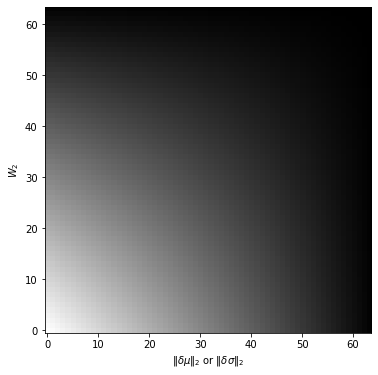

In [3]:
colormap = np.empty((64,64,3))

for i in range(colormap.shape[0]):
    for j in range(colormap.shape[1]):
        colormap[i,j,:] = (64-i)/64 * (64-j)/64
        
plt.figure(figsize=(18,6))
plt.imshow(colormap, origin='lower')
plt.xlabel(r'$\Vert\delta \mu\Vert_2$ or $\Vert\delta \sigma\Vert_2$')
plt.ylabel(r'$W_2$')
plt.show()

# Alpha as the second encoding

In [4]:
width = 10
percent = 5
 
#input_range = 8649.794 # max - min value of sinogram
input_range = 1100
var = np.ones((64,64)) * input_range
Sigma_in = utils.build_covariance_y(var, function=utils.exponential, width=width)

algs = ['ramp', 'cosine', 'hamming', 'hann', 'shepp-logan', 'None']

@widgets.interact(algo1=algs, algo2=algs)
def compare(algo1='ramp', algo2='cosine'):
    mu1 = np.load('../../Data/iradon/mu_'+algo1+'.npy')
    df_dx1 = np.load('../../Data/iradon/df_dx_'+algo1+'.npy')
    Sigma1 = df_dx1 @ Sigma_in @ np.transpose(df_dx1)
    variance1 = np.reshape(np.abs(np.diag(Sigma1)), mu1.shape)
    
    mu2 = np.load('../../Data/iradon/mu_'+algo2+'.npy')
    df_dx2 = np.load('../../Data/iradon/df_dx_'+algo2+'.npy')
    Sigma2 = df_dx2 @ Sigma_in @ np.transpose(df_dx2)
    variance2 = np.reshape(np.abs(np.diag(Sigma2)), mu2.shape)
    
    BD = wasserstein(mu1, variance1, mu2, variance2)
    var_diff = np.abs(variance1 - variance2)
    var_diff /= var_diff.max()
    
    m_diff = np.abs(mu1 - mu2)
    m_diff /= m_diff.max()
    
    plt.figure(figsize=(18,6))
    plt.title('W_2')
    plt.imshow(BD, cmap='Greys')
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(18,6))
    plt.subplot(1,2,1)
    plt.title(r'$W_2$ & $\delta \sigma$')
    plt.imshow(BD, cmap='Greys', alpha=var_diff)
    
    plt.subplot(1,2,2)
    plt.title(r'$W_2$ & $\delta \mu$')
    plt.imshow(BD, cmap='Greys', alpha=m_diff )
    
    plt.show()

interactive(children=(Dropdown(description='algo1', options=('ramp', 'cosine', 'hamming', 'hann', 'shepp-logan…

In [5]:
width = 10
 
#input_range = 8649.794 # max - min value of sinogram
input_range = 1100
var = np.ones((64,64)) * input_range
Sigma_in = utils.build_covariance_y(var, function=utils.exponential, width=width)

algs = ['ramp', 'cosine', 'hamming', 'hann', 'shepp-logan', 'None']

@widgets.interact(algo1=algs, algo2=algs, width=(1,10))
def compare(algo1='ramp', algo2='cosine', width=1):
    mu1 = np.load('../../Data/iradon/mu_'+algo1+'.npy')
    df_dx1 = np.load('../../Data/iradon/df_dx_'+algo1+'.npy')
    Sigma1 = np.abs(df_dx1 @ Sigma_in @ np.transpose(df_dx1))
    variance1 = np.reshape(np.diag(Sigma1), mu1.shape)

    mu2 = np.load('../../Data/iradon/mu_'+algo2+'.npy')
    df_dx2 = np.load('../../Data/iradon/df_dx_'+algo2+'.npy')
    Sigma2 = np.abs(df_dx2 @ Sigma_in @ np.transpose(df_dx2))
    variance2 = np.reshape(np.diag(Sigma2), mu2.shape)

    BD = np.zeros((64*64,))
    alpha_var = np.zeros((64*64,))
    alpha_mu = np.zeros((64*64,))
    alpha_covar = np.zeros((64*64,))
    for p in range(64*64):
        neigbours = utils.get_neighbour_indices(p, width, 64, 64)
        n_flatten = neigbours.flatten().astype(np.int64)
        S1_covar = np.array([[Sigma1[i,j] for i in n_flatten] for j in n_flatten])
        S2_covar = np.array([[Sigma2[i,j] for i in n_flatten] for j in n_flatten])
        M1 = mu1.flatten()[n_flatten]
        M2 = mu2.flatten()[n_flatten]
        
        BD[p] = wasserstein_matrix(M1, S1_covar, M2, S2_covar)
        alpha_mu[p] = np.abs(mu1.flatten()[p] - mu2.flatten()[p])
        alpha_var[p] = np.abs( variance1.flatten()[p] - variance2.flatten()[p] )
        
        # remove the variance and leave only the covariance rho * sigma_i * sigma_j
        S1_co = S1_covar - np.diag(np.diag(S1_covar))
        S2_co = S2_covar - np.diag(np.diag(S2_covar))
        # remove the sigma_i and sigma_j, resulting in rho
        #S1_co /= np.prod(np.diag(S1_covar))
        #S2_co /= np.prod(np.diag(S2_covar))
        
        alpha_covar[p] = np.sum(np.abs(S1_co - S2_co))

    BD = BD.reshape((64,64))
    alpha_var = alpha_var.reshape((64,64))
    alpha_var /= alpha_var.max()
    alpha_mu = alpha_mu.reshape((64,64))
    alpha_mu /= alpha_mu.max()
    alpha_covar = alpha_covar.reshape((64,64))
    alpha_covar /= alpha_covar.max()
    
    plt.figure(figsize=(18,6))
    plt.title(r'$W_2$')
    plt.imshow(BD, cmap='Greys')
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.title(r'$W_2$ & $\delta \mu$')
    plt.imshow(BD, cmap='Greys', alpha=alpha_mu)
    plt.subplot(1,3,2)
    plt.title(r'$W_2$ & $\delta \sigma$')
    plt.imshow(BD, cmap='Greys', alpha=alpha_var)
    plt.subplot(1,3,3)
    plt.title(r'$W_2$ & $\delta \Sigma$')
    plt.imshow(BD, cmap='Greys', alpha=alpha_covar)

    plt.show()

interactive(children=(Dropdown(description='algo1', options=('ramp', 'cosine', 'hamming', 'hann', 'shepp-logan…